In [1]:
import warnings

import torch

from dataset import PIDJSONDataset, get_dataloaders
from trainer import Trainer
from utils import plot_training_curves
from wrapper import Wrapper

warnings.filterwarnings("ignore")

In [2]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
IMAGES_DIR = "dataset/images"
ANN_DIR = "dataset/annotations"
# ---------------- Configuration ----------------
config = {
    "batch_size": 6,
    "epochs": 10,
    "learning_rate": 0.001,
    "train_split": 0.7,
    "val_split": 0.2,
    "test_split": 0.1,
    "iou_threshold": 0.5,
    "confidence_threshold": 0.5,
}

In [3]:
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=config["batch_size"],
    train_split=config["train_split"],
    val_split=config["val_split"],
    num_workers=4,
    images_dir=IMAGES_DIR,
    ann_dir=ANN_DIR,
    symbol_mode='unified',
)

Found 500 annotation files
Loaded 500 diagrams
Mode: unified
Classes: ['background', 'symbol', 'word', 'line'] (4)
Splits - Train: 350, Val: 100, Test: 50


In [4]:
dataset = PIDJSONDataset(
    images_dir=IMAGES_DIR,
    ann_dir=ANN_DIR,
    symbol_mode='unified'
)
num_classes = len(dataset.class_names)  # background + word + line + symbols


Found 500 annotation files
Loaded 500 diagrams
Mode: unified
Classes: ['background', 'symbol', 'word', 'line'] (4)


In [5]:
# Create model wrapper
wrapper = Wrapper(device=device, num_classes=num_classes)

# ---------------- Trainer ----------------
trainer = Trainer(wrapper, device=device, lr=config["learning_rate"])

In [6]:
trainer.train(train_loader, val_loader=val_loader, epochs=config["epochs"])

Training on cuda for 10 epochs

Epoch 1/10


Epoch 1: 100%|██████████| 59/59 [01:07<00:00,  1.14s/it, loss=1.5897]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.5203
Train Loss: 2.0413, Val Loss: 1.5203

Epoch 2/10


Epoch 2: 100%|██████████| 59/59 [01:03<00:00,  1.08s/it, loss=1.3181]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.3936
Train Loss: 1.4850, Val Loss: 1.3936

Epoch 3/10


Epoch 3: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=1.3136]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.2503
Train Loss: 1.3230, Val Loss: 1.2503

Epoch 4/10


Epoch 4: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=1.2739]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.2308
Train Loss: 1.2341, Val Loss: 1.2308

Epoch 5/10


Epoch 5: 100%|██████████| 59/59 [01:08<00:00,  1.17s/it, loss=1.1624]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.2213
Train Loss: 1.2264, Val Loss: 1.2213

Epoch 6/10


Epoch 6: 100%|██████████| 59/59 [01:05<00:00,  1.11s/it, loss=1.2467]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.2135
Train Loss: 1.2238, Val Loss: 1.2135

Epoch 7/10


Epoch 7: 100%|██████████| 59/59 [01:10<00:00,  1.20s/it, loss=1.2263]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.2102
Train Loss: 1.2176, Val Loss: 1.2102

Epoch 8/10


Epoch 8: 100%|██████████| 59/59 [01:04<00:00,  1.10s/it, loss=1.1867]


Train Loss: 1.2173, Val Loss: 1.2166

Epoch 9/10


Epoch 9: 100%|██████████| 59/59 [01:06<00:00,  1.12s/it, loss=1.2862]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.1909
Train Loss: 1.2091, Val Loss: 1.1909

Epoch 10/10


Epoch 10: 100%|██████████| 59/59 [01:10<00:00,  1.19s/it, loss=1.3296]


Train Loss: 1.2141, Val Loss: 1.2228


In [7]:
metrics = trainer.evaluate(
    test_loader,
    iou_threshold=config["iou_threshold"],
    confidence_threshold=config["confidence_threshold"],
    class_names=dataset.class_names,
)

print("\n=== FINAL RESULTS ===")
print(f"mAP (mean Average Precision): {metrics['mAP']:.4f}")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Mean Precision: {metrics['mean_precision']:.4f}")
print(f"Mean Recall: {metrics['mean_recall']:.4f}")
print(f"Mean F1-Score: {metrics['mean_f1']:.4f}")
print(f"Average Inference Time: {metrics['avg_inference_time']:.4f} sec/image")

Evaluating model...


Evaluating: 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]


symbol - Precision: 0.927, Recall: 0.225, F1: 0.362
word - Precision: 0.819, Recall: 0.109, F1: 0.193
line - Precision: 0.000, Recall: 0.000, F1: 0.000

=== FINAL RESULTS ===
mAP (mean Average Precision): 0.5821
Mean IoU: 0.6696
Mean Precision: 0.5821
Mean Recall: 0.1114
Mean F1-Score: 0.1849
Average Inference Time: 0.0705 sec/image


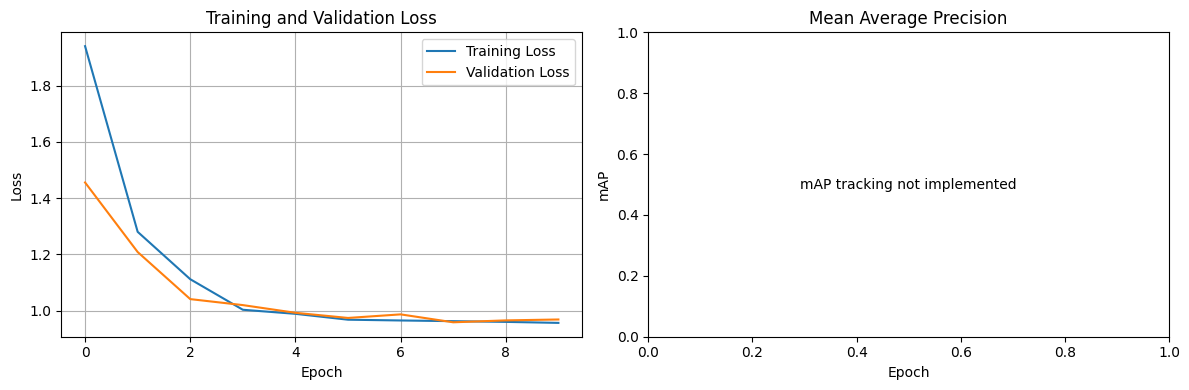

In [10]:
plot_training_curves(trainer, save_path ="models/training_curves.png")

In [8]:
model_path = wrapper.save_model(
    config=config, class_names=dataset.class_names, metrics=metrics, name="final_model"
)

print(f"\nModel saved as '{model_path}'")
print("Training curves saved as 'models/training_curves.png'")

Model saved to: models/final_model.pth

Model saved as 'models/final_model.pth'
Training curves saved as 'models/training_curves.png'
